# Packages

In [97]:
using BenchmarkTools
using Cuba
using LorentzVectors
using Plots
using DelimitedFiles
using DataInterpolations
using Polylogarithms
using LaTeXStrings

# Tolerance integration

In [2]:
tol = 1e-5

1.0e-5

# Constants of nature and Dynkin indices

In [3]:
############  Particle physics and cosmo constant ###############
MP = 2.435*1e18                      #[GeV]     Reduced Planck mass
T0 = 2.72548*1.3806/6.626*1e11*1e-9  #[GHz]     CMB temperature expressed in terms of frequency units
Tmax = 1e15                          #[GeV]     Maximal temperature of the plasma (should change that, maybe as an input parameter)
g_Tmax = 178                         #          # of entropic dofs at the maximal temperature of the plasma
g_Tew = 106.75                       #          # of entropic dofs at the electroweak scale
  

v=174.1                              #[GeV]     Ew vev
mW = 80.379                          #[GeV]     W boson mass
mZ = 91.1876                         #[GeV]     Z boson mass

###########  SM gauge coupling constants  ###########################
alphaew = 1/40 #137          # Fine structure constant at GUT scale for all 3 SM interactions: rude approx to improve
e2 = 4*pi*alphaew
cw = mW/mZ                   # Cosinus of the Weinberg angle
sw = sqrt(1-cw^2)
g1 = sqrt(e2)                # Weak hypercharge coupling at GUT scale
g2 = sqrt(e2)                # Weak isospin (SU(2)) coupling at GUT scale
g3 = sqrt(e2)                # Strong coupling at GUT scale

###########  SM Yukawa couplings  ###########################
mtop = 172.76
mbottom = 4.18
mtau = 1.77686

ytop = mtop/v
ybottom = mbottom/v
ytau = mtau/v

###########  Constants related to SM Lie algebra  ################ 
dimU1 = 1
dimSU2 = 3
dimSU3 = 8

########### Dynkin indices SO(10) ######################
#to change later, I just don't know for now (should be an array)
T_fermion = 1       
T_scalar = 1
T_Ad = 1

########### N_leptons and N_species ######################
#Based on the Dynkin indices

#for the SM provisionally: to change
N_leptons = 3/2      #to change for general case, I just don' know for now
N_species = 11/2     #(sum(T_fermion)+sum(T_scalar))/2
etabar = 1.036^2*(12/pi)^5*(5/2)^3*N_leptons/(9*pi^2+224*N_species)

15.486094632954613

# Thermal masses

In [4]:
function m1(T)
    return 11/6*g1^2
end

function m2(T)
    return 11/6*g2^2
end

function m3(T)
    return 2*g3^2
end

m3 (generic function with 1 method)

# Defining the Bose-Einstein distribution

In [5]:
function nb(x)
    return 1/(exp(x)-1)
end

nb (generic function with 1 method)

# Defining $\hat{\eta}_{\rm{HTL}}$

In [6]:
function etaHTL(T,k)   #k is adimensional momentum ! No dimensions !
    return k/(16*pi*(exp(k)-1))*(dimU1*m1(T)*log(1+4*k^2/m1(T)^2)+dimSU2*m2(T)*log(1+4*k^2/m2(T)^2)+dimSU3*m3(T)*log(1+4*k^2/m3(T)^2))
end

etaHTL (generic function with 1 method)

# Defining the $\hat{\eta}$ functions

In [7]:
############## Define the L_i and M_i functions, necessary for the eta functions ############

function L1p(x,y)
    return log((1-exp(-(x+y)/2))/(1-exp((x-y)/2)))
end
function L1m(x,y)
    return log((1+exp(-(x+y)/2))/(1+exp((x-y)/2)))
end

function L2p(x,y)
    return real(polylog(2,exp((x-y)/2))-polylog(2,exp(-(x+y)/2)))
end
function L2m(x,y)
    return real(polylog(2,-exp((x-y)/2))-polylog(2,-exp(-(x+y)/2)))
end

function L3p(x,y)
    return real(polylog(3,exp((x-y)/2))-polylog(3,exp(-(x+y)/2)))
end
function L3m(x,y)
    return real(polylog(3,-exp((x-y)/2))-polylog(3,-exp(-(x+y)/2)))
end




function M1p(x,y)
    return log((1-exp(-(x-y)/2))/(1-exp(-(x+y)/2)))
end
function M1m(x,y)
    return log((1+exp(-(x-y)/2))/(1+exp(-(x+y)/2)))
end

function M2p(x,y)
    return real(polylog(2,exp(-(x+y)/2))+polylog(2,exp(-(x-y)/2)))
end
function M2m(x,y)
    return real(polylog(2,-exp(-(x+y)/2))+polylog(2,-exp(-(x-y)/2)))
end

function M3p(x,y)
    return real(polylog(3,exp(-(x+y)/2))-polylog(3,exp(-(x-y)/2)))
end
function M3m(x,y)
    return real(polylog(3,-exp(-(x+y)/2))-polylog(3,-exp(-(x-y)/2)))
end


############## Define I,J,K,L's, which are lin. comb. of eta functions ##################

function Ip(k)
    xmin = -100*k
    function boundary1(x)
        return abs(x)
    end
    function boundary2(x)
        return 2*k-x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (k-xmin)*x+xmin
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (k-xmin)*(boundary2(varchangex)-boundary1(varchangex))*((1+nb(varchangex)+nb(k-varchangex))*(-2/3*L1p(varchangex,varchangey)+(varchangey^2-3*(varchangex-2*k)^2)*(12*L3p(varchangex,varchangey)+6*varchangey*L2p(varchangex,varchangey)+varchangey^2*L1p(varchangex,varchangey))/6/varchangey^4)+4*k^2*pi^2/varchangey^4)*(varchangey^2-varchangex^2)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return nb(k)/(256*pi^3*k)*result
end


function Im(k)
    xmin = -100*k
    function boundary1(x)
        return abs(x)
    end
    function boundary2(x)
        return 2*k-x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (k-xmin)*x+xmin
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (k-xmin)*(boundary2(varchangex)-boundary1(varchangex))*((1+nb(varchangex)+nb(k-varchangex))*(-2/3*L1m(varchangex,varchangey)+(varchangey^2-3*(varchangex-2*k)^2)*(12*L3m(varchangex,varchangey)+6*varchangey*L2m(varchangex,varchangey)+varchangey^2*L1m(varchangex,varchangey))/6/varchangey^4)-2*k^2*pi^2/varchangey^4)*(varchangey^2-varchangex^2)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return nb(k)/(256*pi^3*k)*result
end


function Jp(k)
    xmax = 100*k
    function boundary1(x)
        return abs(2*k-x)
    end
    function boundary2(x)
        return x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (xmax-k)*x+k
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (xmax-k)*(boundary2(varchangex)-boundary1(varchangex))*(nb(varchangex-k)-nb(varchangex))*(varchangey^2-varchangex^2)*(1/3*(2*M1p(varchangex,varchangey)-varchangey)-(varchangey^2-3*(varchangex-2*k)^2)*(12*M3p(varchangex,varchangey)+6*varchangey*M2p(varchangex,varchangey)+varchangey^2*M1p(varchangex,varchangey))/6/varchangey^4)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return nb(k)/(256*pi^3*k)*result
end


function Jm(k)
    xmax = 100*k
    function boundary1(x)
        return abs(2*k-x)
    end
    function boundary2(x)
        return x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (xmax-k)*x+k
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (xmax-k)*(boundary2(varchangex)-boundary1(varchangex))*(nb(varchangex-k)-nb(varchangex))*(varchangey^2-varchangex^2)*(1/3*(2*M1m(varchangex,varchangey)-varchangey)-(varchangey^2-3*(varchangex-2*k)^2)*(12*M3m(varchangex,varchangey)+6*varchangey*M2m(varchangex,varchangey)+varchangey^2*M1m(varchangex,varchangey))/6/varchangey^4)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return nb(k)/(256*pi^3*k)*result
end
     

function K(k)
    xmin = -100*k
    function boundary1(x)
        return abs(x)
    end
    function boundary2(x)
        return 2*k-x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (k-xmin)*x+xmin
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (k-xmin)*(boundary2(varchangex)-boundary1(varchangex))*(1+nb(varchangex)+nb(k-varchangex))*L1m(varchangex,varchangey)*(varchangey^2-varchangex^2)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return -nb(k)/(256*pi^3*k)*result
end


function L(k)
    xmax = 100*k
    function boundary1(x)
        return abs(2*k-x)
    end
    function boundary2(x)
        return x
    end
    function integrand(xx,ff)
        x,y=xx
        varchangex = (xmax-k)*x+k
        varchangey = (boundary2(varchangex)-boundary1(varchangex))*y+boundary1(varchangex)
        ff[1] = (xmax-k)*(boundary2(varchangex)-boundary1(varchangex))*(nb(varchangex-k)-nb(varchangex))*(2*M1m(varchangex,varchangey)-varchangey)*(varchangey^2-varchangex^2)
    end
    result = cuhre(integrand,atol = tol, rtol = tol).integral[1]
    return nb(k)/(256*pi^3*k)*result
end







################ Define the eta functions ###################

function etagg(k)
    return -4*(Ip(k)+Jp(k))
end

function etasg(k)
    return -(Ip(k)+Jp(k))
end

function etasf(k)
    return 4*K(k)+2*L(k)
end

function etafg(k)
    return 4*(Im(k)+Jm(k))
end


etafg (generic function with 1 method)

In [8]:
start_time=time()
println(etasf(1))
println('\n',time()-start_time, " sec")

0.00129619265400233

0.25872302055358887 sec


# GW spectrum

In [51]:
function eta_tot(T,k)
    if k<alphaew^2
        return etabar/g1^4/log(5/m1(T))
    elseif k>m3(T) 
        #println(etagg(k)," ",etasg(k)," ",etafg(k)," ",etasf(k))
        return etaHTL(T,k)+(3*g2^2+12*g3^2)*etagg(k)+(g1^2+3*g2^2)*etasg(k)+(5*g1^2+9*g2^2+24*g3^2)*etafg(k)+(3*ytop^2+3*ybottom^2+ytau^2)*etasf(k)
    else
        return 0
    end
end

function h2OmegaSM(f,Tmax)                  # f should be expressed in GHz !
    g_TmaxSM = 106.75
    #println(2*pi*f/T0*(g_TmaxSM/g_Tew)^(1/3))
    return 4.03e-12*Tmax/MP*(g_TmaxSM/106.75)^(-5/6)*f^3*eta_tot(Tmax,2*pi*f/T0*(g_TmaxSM/g_Tew)^(1/3))
end

function h2Omega(f,Tmax)                  # f should be expressed in GHz !
    return 4.03e-12*Tmax/MP*(g_Tmax/106.75)^(-5/6)*f^3*eta_tot(Tmax,2*pi*f/T0*(g_Tmax/g_Tew)^(1/3))
end

h2Omega (generic function with 1 method)

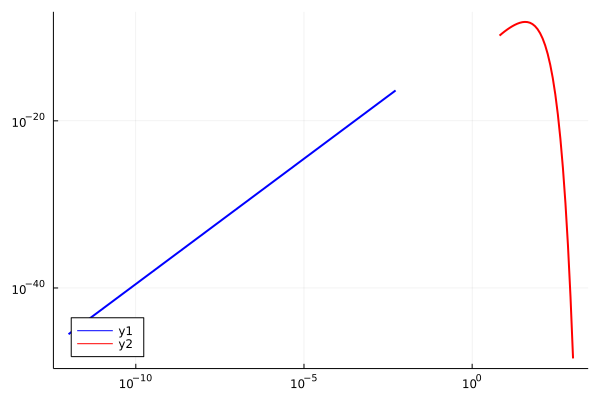

In [72]:
Tmax=MP
Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = h2OmegaSM(farray[i],Tmax)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)
#plot(farray[x],GWarray[x],xaxis=:log,yaxis=:log,lw=2)
plot(farray[1:y[1]-1],GWarray[1:y[1]-1],xaxis=:log,yaxis=:log,lw=2,color=:blue,legend=:bottomleft)
plot!(farray[last(y)+1:200],GWarray[last(y)+1:200],xaxis=:log,yaxis=:log,lw=2,color=:red,legend=:bottomleft)
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-23:-3))
xticks!(x_ticks)
yticks!(y_ticks)

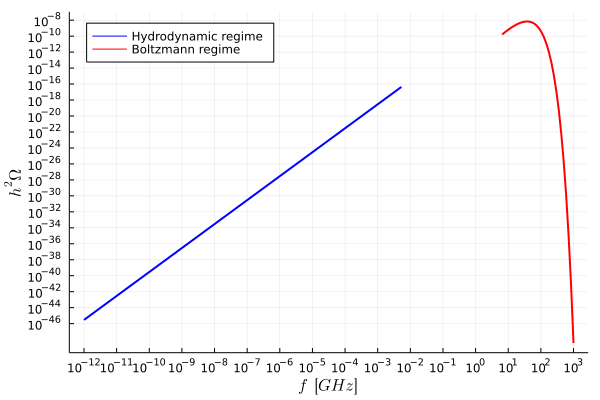

In [105]:
p = plot(farray[1:y[1]-1],GWarray[1:y[1]-1],xaxis=:log,yaxis=:log,lw=2,color=:blue,legend=:topleft,label="Hydrodynamic regime",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
p = plot!(farray[last(y)+1:200],GWarray[last(y)+1:200],xaxis=:log,yaxis=:log,lw=2,color=:red,legend=:topleft,label="Boltzmann regime")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-23:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/GW_from_SM.pdf")